In [1]:
import pandas as pd
df = pd.read_excel("../Dataset/news_excerpts_parsed.xlsx")

In [2]:
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])
    return text

# Apply preprocessing to the text data
df['clean_text'] = df['Text'].apply(preprocess_text)

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    max_df=0.85,  
    min_df=5,     
    stop_words='english', 
    ngram_range=(1, 2)  
)

X_tfidf = tfidf_vectorizer.fit_transform(df['Text'])

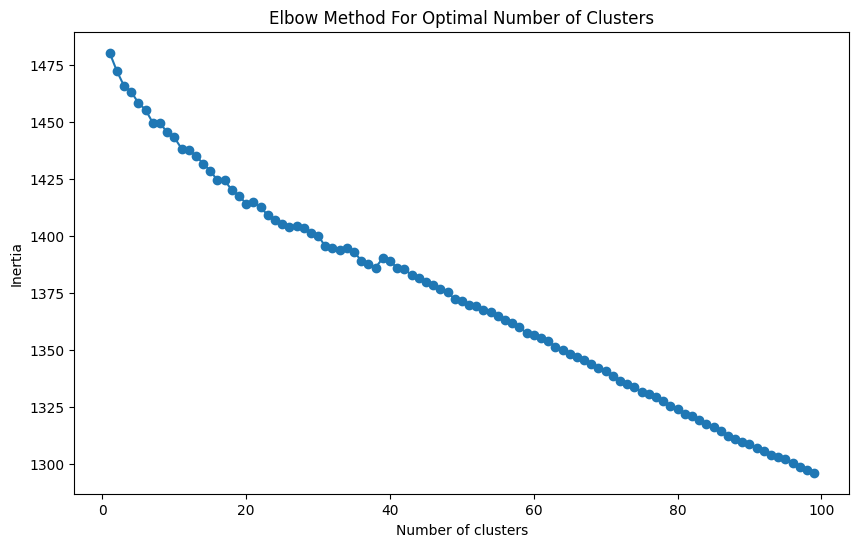

In [4]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate inertia for different numbers of clusters
inertia = []
num_clusters_range = range(1, 100)
for num_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(X_tfidf)
    inertia.append(kmeans.inertia_)

# Plot the elbow method graph
plt.figure(figsize=(10, 6))
plt.plot(num_clusters_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()

The number of clusters with the highest silhouette score is: 99


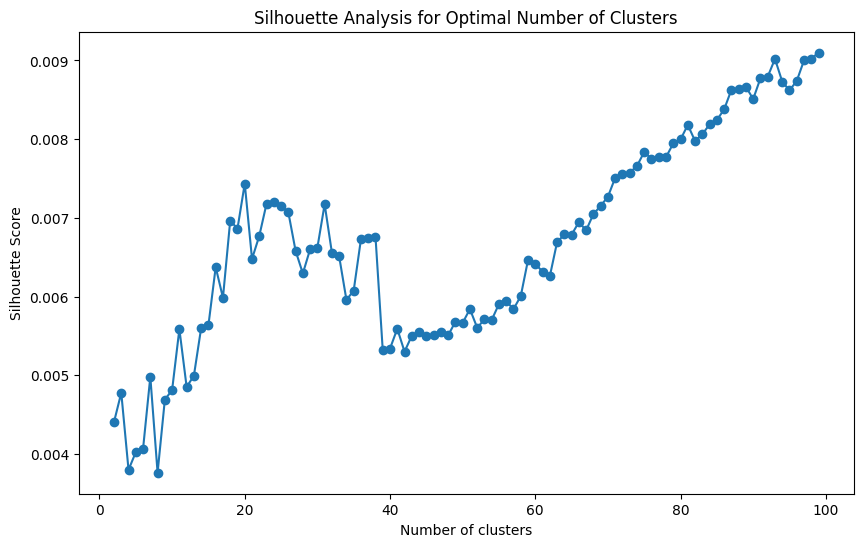

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Perform silhouette analysis
silhouette_scores = []
num_clusters_range = range(2, 100)  # Silhouette analysis starts from 2 clusters

for num_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_tfidf)
    score = silhouette_score(X_tfidf, cluster_labels)
    silhouette_scores.append(score)

# Find the number of clusters with the highest silhouette score
best_num_clusters = num_clusters_range[silhouette_scores.index(max(silhouette_scores))]
print(f'The number of clusters with the highest silhouette score is: {best_num_clusters}')

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(num_clusters_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal Number of Clusters')
plt.show()

In [6]:
from sklearn.cluster import KMeans

# Apply K-Means with a predetermined number of clusters

kmeans = KMeans(n_clusters=best_num_clusters, random_state=42)
kmeans.fit(X_tfidf)

# Get the cluster assignments
labels_kmeans = kmeans.labels_
df['kmean_cluster'] = labels_kmeans


In [7]:
import numpy as np

# Get cluster centers
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

# Get feature names (words)
terms = tfidf_vectorizer.get_feature_names_out()

# Display top words per cluster

top_10_words = ''
for i in range(num_clusters):
    top_10_words += f"Cluster {i}: "+", ".join([terms[ind] for ind in order_centroids[i, :10]])+"\n"
    print(f"Cluster {i}: ", end="")
    print(", ".join([terms[ind] for ind in order_centroids[i, :10]]))

Cluster 0: cuba, trail, net, calls, near, body, died, little, data, family
Cluster 1: cent, china, billion, exports, united states, united, states, meat, year, deficit
Cluster 2: party, federal, said, arrested, political, crime, government, case, ministry said, ministry
Cluster 3: china, trump, foreign, chinese, foreign ministry, beijing, ministry, president, taiwan, united states
Cluster 4: real estate, estate, house, real, property, services, cheng, kazakhstan, company, china
Cluster 5: green, club, forest, world, fifa, weather, said, dish, spain, carbon
Cluster 6: openai, intelligence, artificial intelligence, artificial, ai, chatgpt, company, microsoft, said, model
Cluster 7: fish, away, noodles, miles, robot, grew, water, rice, shop, lay
Cluster 8: al, gaza, mohammed, hospital, said, aid, afp, israeli, told, told afp
Cluster 9: chinese, basketball, li, obtained, china, citizenship, world cup, association, cup, according
Cluster 10: sanctions, russian, russia, treasury, ukraine, na

In [8]:
grouped_df = df.groupby('kmean_cluster', as_index=True).agg({'Text': ' '.join})

In [13]:
import google.generativeai as genai
import os
from dotenv import load_dotenv

load_dotenv()
model = genai.GenerativeModel(model_name='gemini-1.5-flash',
                              system_instruction="""
                              Classify cluster topics name for each cluster based on the top 10 words for each cluster. 
                              Ensure that each cluster topics is maximum of 3 words. 
                              Respond **ONLY** as such: start with '[', name the topic within '', seperated by ' ,' and lastly ends with ']'
                              """)
genai.configure(api_key=os.getenv("GEMINI_KEY"))
response = model.generate_content(top_10_words)
print(response)
cluster_ls = eval(response.text)
cluster_ls

response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "['Cuba Trail Data', 'China US Trade', 'Political Crime Case', 'China US Taiwan', 'Real Estate China', 'Green World Club', 'Artificial Intelligence AI', 'Robot Fish Noodles', 'Gaza Israeli Aid', 'China Basketball Cup', 'Russia Ukraine Sanctions', 'Medical Health Surgery', 'NUS Medicine Team', 'Malaysia Singapore Relations', 'North Korea South', 'Taiwan School Years', 'Singapore Research University', 'Cybersecurity Law Comment', 'Music Film Singer', 'Elon Musk Twitter', 'Turkey UAE Trade', 'India Russia Weapons', 'Singapore School Student', 'Korean Singapore Food', 'Digital Payments Cards', 'Hospital Sports Injury', 'Woman Year Old Victim', 'Accident Witness Bush', 'Nigeria Oil Charges', 'Hong Kong China', 'Investment UK Data', 'Coconut Food Outlets', 'Restaur

['Cuba Trail Data',
 'China US Trade',
 'Political Crime Case',
 'China US Taiwan',
 'Real Estate China',
 'Green World Club',
 'Artificial Intelligence AI',
 'Robot Fish Noodles',
 'Gaza Israeli Aid',
 'China Basketball Cup',
 'Russia Ukraine Sanctions',
 'Medical Health Surgery',
 'NUS Medicine Team',
 'Malaysia Singapore Relations',
 'North Korea South',
 'Taiwan School Years',
 'Singapore Research University',
 'Cybersecurity Law Comment',
 'Music Film Singer',
 'Elon Musk Twitter',
 'Turkey UAE Trade',
 'India Russia Weapons',
 'Singapore School Student',
 'Korean Singapore Food',
 'Digital Payments Cards',
 'Hospital Sports Injury',
 'Woman Year Old Victim',
 'Accident Witness Bush',
 'Nigeria Oil Charges',
 'Hong Kong China',
 'Investment UK Data',
 'Coconut Food Outlets',
 'Restaurant Italian Food',
 'Court Legal Prison',
 'Cancer Health Diagnosis',
 'Mr Tay Enterprise',
 'Ancient Greek Sculptures',
 'Medical Patient Care',
 'Singapore Born Years',
 'Apple Market Share',
 'Data

In [14]:
# Create a new DataFrame with kmean_cluster and cluster_ls
df_clusters = pd.DataFrame({
    'kmean_cluster': range(len(cluster_ls)),
    'Topic': cluster_ls
})

# Concatenate the new DataFrame with grouped_df
grouped_df = pd.concat([df_clusters, grouped_df.reset_index(drop=True)], axis=1)
grouped_df.head()

,kmean_cluster,Topic,Text
0,0,Cuba Trail Data,Cuba´s economy is suffering unprecedented cris...
1,1,China US Trade,China has for years been guiding money into it...
2,2,Political Crime Case,"This morning, Angjelin Sterkaj was sentenced t..."
3,3,China US Taiwan,A Manhattan jury has found two Trump Organizat...
4,4,Real Estate China,Four Czech neo-Nazis were sentenced Wednesday ...


In [15]:
import google.generativeai as genai
import os
from dotenv import load_dotenv

load_dotenv()
model = genai.GenerativeModel(model_name='gemini-1.5-flash',
                              system_instruction="""
Conduct **Relationship Extraction** on the given input. 

### **Expected Output Format**
Respond **ONLY** with two Python lists and NOT IN PYTHON, separated by `Ω≈`:
1. **Entities List**: List of tuples containing (entity_name, classification), where:
   - `entity_name`: Maximum of **three words**.
   - `classification`: Must be one of the following:
     - `PER` (Person)
     - `ORG` (Organisation)
     - `LOC` (Location)
     - `EVT` (Event)
   - **No duplicate entities allowed.**
   - **Every entity must have at least one relationship.**

2. **Relationships List**: List of tuples containing (entity_1, entity_2, relationship_label, relationship_classification), where:
   - `entity_1`, `entity_2`: Must be present in the **Entities List**.
   - `relationship_label`: Maximum of **three words**.
   - `relationship_classification`: Must be one of the following:
     - `PV` (Positive sentiment)
     - `NG` (Negative sentiment)
     - `NE` (Neutral sentiment)
   - **No duplicate relationships allowed.**
   - **Ensure that every identified relationship is valid and meaningful.**
   - **All relationships must have entities that exist in the Entities List.**

### **Processing Rules**
- **Strictly use the specified classifications**; do not identify anything outside them.
- **Ensure high accuracy** in entity recognition and classification.
- **Each entity must be related to at least one other entity**.
- **Ensure that every relationship label is concise, meaningful, and accurate**.
- **Avoid misclassifying generic nouns as entities unless they fit within the specified categories.**

### **Example Output Format**
[("John Doe", "PER"), ("Google", "ORG"), ("New York", "LOC"), ("Tech Summit", "EVT")] @ 
[("John Doe", "Google", "works at", "PV"), ("Tech Summit", "Google", "sponsored by", "PV")]
""")
genai.configure(api_key=os.getenv("GEMINI_KEY"))

In [16]:
def prompt(input):
    response = model.generate_content(input)
    return response.text
def str_to_ls(str):
    entities_str, relationships_str = str.split('Ω≈')
    entities = eval(entities_str.strip())
    relationships = eval(relationships_str.strip())
    return entities, relationships

In [17]:
import time
from tqdm import tqdm

graph_data = []

# Process the first half of the rows
half_index = len(grouped_df) // 2
for index, row in tqdm(grouped_df.iloc[:half_index].iterrows(), total=half_index, desc="Processing rows"):
    text = row['Text']
    
    # Making the API call
    res = prompt(text)
    
    # Parsing the response
    entities, relationships = str_to_ls(res)
    
    # Appending results to list
    graph_data.append({'Entities': entities, 'Relationships': relationships})

Processing rows:   0%|          | 0/49 [00:00<?, ?it/s]

Processing rows: 100%|██████████| 49/49 [05:39<00:00,  6.92s/it]


In [18]:
# Process the second half of the rows
for index, row in tqdm(grouped_df.iloc[half_index:].iterrows(), total=len(grouped_df) - half_index, desc="Processing remaining rows"):
    text = row['Text']
    
    # Making the API call
    res = prompt(text)
    
    # Parsing the response
    entities, relationships = str_to_ls(res)
    
    # Appending results to list
    graph_data.append({'Entities': entities, 'Relationships': relationships})

# Convert to DataFrame
graph_df = pd.DataFrame(graph_data)


Processing remaining rows: 100%|██████████| 50/50 [05:05<00:00,  6.11s/it]


In [19]:
graph_df.insert(0, 'Topic', grouped_df['Topic'])
graph_df.to_csv('news_networks.csv', index=False)
graph_df.head()

,Topic,Entities,Relationships
0,Cuba Trail Data,"[(Cuba's economy, ORG), (Andres Manuel Lopez O...","[(Cuba's economy, Cuba, suffering, NG), (Andre..."
1,China US Trade,"[(China, LOC), (United States, LOC), (Changxin...","[(China, United States, conflict with, NG), (C..."
2,Political Crime Case,"[(Angjelin Sterkaj, PER), (Armando Beqirai, PE...","[(Angjelin Sterkaj, Armando Beqirai, murdered,..."
3,China US Taiwan,"[(Manhattan jury, ORG), (Trump Organization, O...","[(Manhattan jury, Trump Organization, found gu..."
4,Real Estate China,"[(David Vaculik, PER), (Ivo Mueller, PER), (Ja...","[(David Vaculik, Adolf Hitler, attack on Hitle..."


In [58]:
from pyvis.network import Network

# Define dynamic color scheme
node_colors = {
"PER": "#FFA500",  # Orange
"ORG": "#007BFF",  # Blue
"LOC": "#8E44AD",  # Purple
"EVT": "#1ABC9C",  # Teal
"MISC": "#BDC3C7"  # Grey
}

relationship_colors = {
"PV": "#27AE60",  # Green (Positive)
"NG": "#E74C3C",  # Red (Negative)
"NE": "#D3D3D3"   # Light Grey (Neutral)
}

counter=0
for ind, row in graph_df.iterrows():
    topic = row['Topic']
    entities = row["Entities"]
    entities = [entity for entity in entities if len(entity) == 2]
    relationships = row["Relationships"]
    relationships = [relationship for relationship in relationships if len(relationship) == 4]
    
    for ent1, ent2, rs, classification in relationships:
        if ent1 not in [entity for entity, _ in entities]:
            entities.append((ent1, "MISC"))
        if ent2 not in [entity for entity, _ in entities]:
            entities.append((ent2, "MISC"))
    
    # Create PyVis Network
    net = Network(width="100%", height="100vh", notebook=True, directed=True, cdn_resources='remote', bgcolor='#222222', font_color='white')

    # Add nodes with color-coded styles
    for entity, classification in entities:
        color = node_colors.get(classification, "#BDC3C7") 
        net.add_node(entity, label=entity, size=30, borderWidth=4, borderWidthSelected=8,
                        color={"highlight": {"border": color}, "background": color, "border": color},
                        font={'size': 18, 'color': 'white'})

    # Add edges with relationship colors
    for source, target, rs, classification in relationships:
        net.add_edge(source, target, label=rs, width=5,
                    font={'size': 14, 'align': 'middle', 'color': 'white', "strokeColor": "rgba(0,0,0,0)", "vadjust": -10},
                    color=relationship_colors.get(classification, "#FFFFFF"))

    # Improve physics settings for better visualization
    net.set_options("""
    var options = {
    "physics": {
        "barnesHut": {
            "gravitationalConstant": -5050,
            "centralGravity": 0.75,
            "springLength": 180,
            "damping": 0.5,
            "avoidOverlap": 1
        }
    }
    }
    """)
    counter
    name_counter = str(counter).zfill(3)
    file_path = f"news_graph/graph_{name_counter}_{topic}.html"
    counter+=1
    net.show(file_path)

    # Inject **DYNAMIC LEGEND** into HTML file
    legend_html = f"""
    <style>
        .legend {{
            position: absolute;
            top: 20px;
            right: 20px;
            background: white;
            padding: 10px;
            border-radius: 5px;
            font-size: 14px;
            font-family: Arial, sans-serif;
            z-index: 1000;
        }}
        .legend-item {{
            display: flex;
            align-items: center;
            margin-bottom: 5px;
        }}
        .legend-color {{
            width: 15px;
            height: 15px;
            margin-right: 5px;
            border-radius: 3px;
        }}
    </style>
    <div class="legend">
        <strong>Legend</strong>
        <div class="legend-item"><div class="legend-color" style="background:{node_colors["PER"]}"></div>Person (PER)</div>
        <div class="legend-item"><div class="legend-color" style="background:{node_colors["ORG"]}"></div>Organisation (ORG)</div>
        <div class="legend-item"><div class="legend-color" style="background:{node_colors["LOC"]}"></div>Location (LOC)</div>
        <div class="legend-item"><div class="legend-color" style="background:{node_colors["EVT"]}"></div>Event (EVT)</div>
        <div class="legend-item"><div class="legend-color" style="background:{node_colors["MISC"]}"></div>Miscellaneous (MISC)</div>
        <hr>
        <div class="legend-item"><div class="legend-color" style="background:{relationship_colors["PV"]}"></div>Positive (PV)</div>
        <div class="legend-item"><div class="legend-color" style="background:{relationship_colors["NG"]}"></div>Negative (NG)</div>
        <div class="legend-item"><div class="legend-color" style="background:{relationship_colors["NE"]}"></div>Neutral (NE)</div>
    </div>
    """

    # Append dynamic legend to HTML file
    with open(file_path, "a") as f:
        f.write(legend_html)

news_graph/graph_0_Miscellaneous.html
news_graph/graph_1_Trade & Economy.html
news_graph/graph_2_Politics & Government.html
news_graph/graph_3_China & Foreign Relations.html
news_graph/graph_4_Real Estate & Property.html
news_graph/graph_5_Environment & Sports.html
news_graph/graph_6_Artificial Intelligence & Technology.html
news_graph/graph_7_Food & Culture.html
news_graph/graph_8_Middle East & Conflicts.html
news_graph/graph_9_Sports & Citizenship.html
news_graph/graph_10_Russia & Sanctions.html
news_graph/graph_11_Healthcare & Surgery.html
news_graph/graph_12_Medical Research & Virus.html
news_graph/graph_13_Diplomatic Relations & Airlines.html
news_graph/graph_14_Korea & Military.html
news_graph/graph_15_Education & Personal Stories.html
news_graph/graph_16_University Research & Carbon.html
news_graph/graph_17_Cybersecurity & Law.html
news_graph/graph_18_Entertainment & Film.html
news_graph/graph_19_Social Media & Elon Musk.html
news_graph/graph_20_Trade & International Relations.h